In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dog-cat/vit-cat-dog/dogs/dog1023.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog1878.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog1081.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog3445.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog515.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog171.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog2541.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog2448.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog1047.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog2379.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog1995.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog110.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog2315.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog1488.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog3647.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog294.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog2112.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog1581.jpg
/kaggle/input/dog-cat/vit-cat-dog/dogs/dog2039.jpg
/kaggle/input/dog-cat/vit-cat-dog/d

In [81]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

import os
import cv2
import numpy as np
from PIL import Image
from dataclasses import dataclass

import matplotlib.pyplot as plt

In [82]:
# path = os.path.join ("vit-cat-dog", "cats", 'cat2.jpg')
path = os.path.join ("/", "kaggle", "input", "dog-cat", "vit-cat-dog", "dogs", 'dog2.jpg')

In [83]:
image = Image.open (path)

transform = transforms.Compose ([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

img = transform (image)

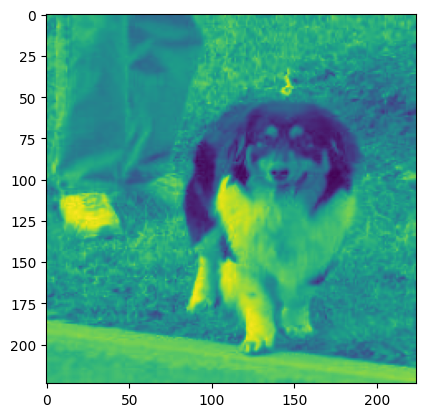

In [84]:
plt.imshow (img.permute (1, 2, 0))

In [85]:
@dataclass
class ViTConfig:
    def __init__ (self, **kwargs):
        for k, v in kwargs.items ():
            setattr (self, k, v)
            
        self.d_k = self.d_model // self.n_head
        self.tok_len = self.patch_size ** 2

        # add one bacuause of the prediction token
        self.seq_len = (self.h_image // self.patch_size) * (self.w_image // self.patch_size) + 1

In [86]:
C, H, W = img.shape
C, H, W

(1, 224, 224)

In [92]:
class PatchTokenizer (nn.Module):
    def __init__ (self, config: ViTConfig):
        super (PatchTokenizer, self).__init__ ()

        self.windows = nn.Unfold (kernel_size=config.patch_size, stride=config.patch_size, padding=0)

        # projection for converting into the required dimention using nn.Linear ()
        self.project = nn.Linear ((config.patch_size ** 2), config.tok_len)

    def forward (self, x):
        # transpose for multiplying (a, b) with (b, a)
        x = self.windows (x).transpose (1, 2)
        x = self.project (x)
        return x

In [93]:
class LearnablePositionalEncoder (nn.Module):
    def __init__ (self, config: ViTConfig):
        super (LearnablePositionalEncoder, self).__init__ ()
        self.pos_encoding = nn.Parameter (torch.zeros (1, config.seq_len, config.tok_len), requires_grad=True)

    def forward (self, x):
        out = self.pos_encoding + x
        return out

In [94]:
class Head (nn.Module):
    def __init__ (self, config: ViTConfig):
        super (Head, self).__init__ ()

        self.query = nn.Linear (config.d_model, config.d_k)
        self.key = nn.Linear (config.d_model, config.d_k)
        self.value = nn.Linear (config.d_model, config.d_k)

        self.linear = nn.Linear (config.d_k, config.d_k)
        
    def forward (self, x):

        # x.shape (batch, seq_len, d_model)
        B, T, D = x.shape

        Q = self.query (x)
        K = self.key (x)
        V = self.value (x)

        attn = Q @ K.permute (0, 2, 1)
        attn = attn / (config.d_k ** (1 / 2))
        attn = F.softmax (attn, dim=-1)
        
        out = (attn @ V)
        out = self.linear (out)

        return out

In [95]:
class Attention (nn.Module):
    def __init__ (self, config: ViTConfig):
        super (Attention, self).__init__ ()

        self.heads = nn.ModuleList ([Head (config) for _ in range (config.n_head)])
        self.linear = nn.Linear (config.n_head * config.d_k, config.d_model)
        
    def forward (self, x):
        out = torch.cat ([head (x) for head in self.heads], dim=-1)
        out = self.linear (out)

        return out

In [96]:
class FeedForward (nn.Module):
    def __init__ (self, config: ViTConfig):
        super (FeedForward, self).__init__ ()

        self.norm = nn.LayerNorm (config.d_model)
        self.fc1 = nn.Linear (config.d_model, config.d_model * config.chan_mul)
        self.fc2 = nn.Linear (config.d_model * config.chan_mul, config.d_model)
        self.activation = nn.GELU ()

    def forward (self, x):
        x = self.norm (x)
        x = self.fc1 (x)
        x = self.activation (x)
        out = self.fc2 (x)

        return out

In [97]:
class Encoder (nn.Module):
    def __init__ (self, config: ViTConfig):
        super (Encoder, self).__init__ ()

        self.norm1 = nn.LayerNorm (config.d_model)
        self.norm2 = nn.LayerNorm (config.d_model)

        self.attention = Attention (config)
        self.feed_forward = FeedForward (config)

    def forward (self, x):
        x = x + self.attention (self.norm1 (x))
        x = x + self.feed_forward (self.norm2 (x))
        return x

In [98]:
class ViT (nn.Module):
    def __init__ (self, config: ViTConfig):
        super (ViT, self).__init__ ()

        self.wpe = LearnablePositionalEncoder (config)
        self.cls = nn.Parameter (torch.zeros (1, 1, config.tok_len), requires_grad=True)
        self.project = nn.Linear (config.tok_len, config.d_model)

        self.blocks = nn.Sequential (*[Encoder (config) 
                                       for _ in range (config.n_layer)])

        self.linear = nn.Linear (config.d_model, 2)
        self.norm = nn.LayerNorm (config.d_model)

    def forward (self, x):
        B, T, D = x.shape

        x = torch.cat ((self.cls.expand (B, -1, -1), x), dim=1)
        x = self.wpe (x)
        x = self.project (x)

        out = self.blocks (x)
        out = out[:, 0]
        out = self.norm (out)
        logits = self.linear (out)

        return logits

In [99]:
class ViTModel (nn.Module):
    def __init__ (self, config: ViTConfig):
        super (ViTModel, self).__init__ ()

        self.patch_tokens = PatchTokenizer (config)
        self.vit = ViT (config)

    def forward (self, x):
        # x (C, H, W)
        x = self.patch_tokens (x) # x (B, T, D)
        logits = self.vit (x)

        return logits

In [100]:
class CatDogDataset (Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = list ()
        self.labels = list ()

        for label, class_name in enumerate(['cats', 'dogs']):
            class_dir = os.path.join(root_dir, class_name)
            for file_name in os.listdir(class_dir):
                if file_name[0] == '.':
                    continue

                self.image_paths.append(os.path.join(class_dir, file_name))
                self.labels.append(label)

    def __len__(self):
        return len (self.labels)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [101]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
    
cat_dog = CatDogDataset (os.path.join ('/', 'kaggle', 'input', 'dog-cat', 'vit-cat-dog'), transform=transform)

In [102]:
train_size = int (0.8 * len (cat_dog))
test_size = len (cat_dog) - train_size
train_dataset, test_dataset = random_split (cat_dog, [train_size, test_size])

In [103]:
train = DataLoader (train_dataset, batch_size=config.batch_size, shuffle=True)
test = DataLoader (test_dataset, batch_size=config.batch_size, shuffle=False)

In [104]:
def calculate_accuracy (model, dataloader, device):
    model.eval ()
    correct = 0
    total = 0
    
    with torch.no_grad ():
        for images, labels in dataloader:
            images = images.to (device)
            labels = labels.to (device)

            logits = model (images)
            _, predicted = torch.max (logits, dim=1)
            
            correct += (predicted == labels).sum ().item ()
            total += labels.size (0)
    
    accuracy = correct / total if total > 0 else 0.0
    return accuracy

In [105]:
test_accuracies = list ()

In [106]:
import sys

def train_vit (lr, optim, config):
    print (f'Training started..!')
    vit = ViTModel (config)
    vit = vit.to (device)
    
    criterion = nn.CrossEntropyLoss ()
    optimizer = optim (params=vit.parameters(), lr=lr)
    max_test_accuracy = -sys.maxsize
    accuracies = list ()
    
    for epoch in range (config.epochs):
        vit.train ()
        accum_loss = 0.0

        for images, labels in train:
            optimizer.zero_grad ()

            images = images.to (device)
            labels = labels.to (device)

            out = vit (images)
            loss = criterion (out, labels)
            loss.backward ()

            accum_loss += loss.item ()

            optimizer.step ()

        test_accuracy = calculate_accuracy (vit, test, device)
        accuracies.append (test_accuracy)
        avg_loss = accum_loss / len (train)
        max_test_accuracy = max (max_test_accuracy, test_accuracy)

        print(f'Epoch ({epoch + 1}/{config.epochs}), Loss: ({avg_loss:.4f}) Test Acc: ({test_accuracy:.4f})')
    
    test_accuracies.append (accuracies)
    print (f'Training ended with {max_test_accuracy} test accuracy, {calculate_accuracy (vit, train, device)} train accuracy!')
    torch.save (vit.state_dict (), f'KViT{int (max_test_accuracy * 100)}A{config.epochs}E.pth')

In [107]:
configs = [
    ViTConfig (n_head=4, n_layer=4, d_model=512, h_image=H, w_image=W, epochs=35, patch_size=16, chan_mul=4, batch_size=8),
    ViTConfig (n_head=8, n_layer=6, d_model=768, h_image=H, w_image=W, epochs=30, patch_size=16, chan_mul=4, batch_size=16),
    ViTConfig (n_head=6, n_layer=8, d_model=1024, h_image=H, w_image=W, epochs=25, patch_size=32, chan_mul=8, batch_size=32),
    ViTConfig (n_head=4, n_layer=4, d_model=512, h_image=H, w_image=W, epochs=40, patch_size=16, chan_mul=4, batch_size=16),
    ViTConfig (n_head=8, n_layer=6, d_model=768, h_image=H, w_image=W, epochs=35, patch_size=16, chan_mul=4, batch_size=8),
    ViTConfig (n_head=6, n_layer=8, d_model=1024, h_image=H, w_image=W, epochs=30, patch_size=32, chan_mul=8, batch_size=16),
    ViTConfig (n_head=4, n_layer=4, d_model=512, h_image=H, w_image=W, epochs=25, patch_size=16, chan_mul=4, batch_size=32),
    ViTConfig (n_head=8, n_layer=6, d_model=768, h_image=H, w_image=W, epochs=40, patch_size=16, chan_mul=4, batch_size=32),
    ViTConfig (n_head=6, n_layer=8, d_model=1024, h_image=H, w_image=W, epochs=35, patch_size=32, chan_mul=8, batch_size=8),
    ViTConfig (n_head=4, n_layer=4, d_model=512, h_image=H, w_image=W, epochs=30, patch_size=16, chan_mul=4, batch_size=16)
]

optims = [
    (optim.SGD, 0.001),
    (optim.Adam, 0.0005),
    (optim.Adadelta, 0.01),
    (optim.AdamW, 0.0001),
    (optim.Adagrad, 0.002),
    (optim.Adamax, 0.0003),
    (optim.RMSprop, 0.0015),
    (optim.Adam, 0.0002),
    (optim.Adadelta, 0.005),
    (optim.AdamW, 0.0004)
]

In [108]:
for config, (optim, lr) in zip (configs, optims):
    train_vit (lr, optim, config)

Training started..!
Epoch (1/35), Loss: (0.7296) Test Acc: (0.5170)
Epoch (2/35), Loss: (0.7062) Test Acc: (0.4830)
Epoch (3/35), Loss: (0.7078) Test Acc: (0.5170)
Epoch (4/35), Loss: (0.7046) Test Acc: (0.4837)
Epoch (5/35), Loss: (0.7000) Test Acc: (0.5583)
Epoch (6/35), Loss: (0.6984) Test Acc: (0.4997)
Epoch (7/35), Loss: (0.6990) Test Acc: (0.5108)
Epoch (8/35), Loss: (0.6990) Test Acc: (0.5170)
Epoch (9/35), Loss: (0.6947) Test Acc: (0.4843)
Epoch (10/35), Loss: (0.6942) Test Acc: (0.5435)
Epoch (11/35), Loss: (0.6962) Test Acc: (0.5706)
Epoch (12/35), Loss: (0.6930) Test Acc: (0.5170)
Epoch (13/35), Loss: (0.6942) Test Acc: (0.5170)
Epoch (14/35), Loss: (0.6941) Test Acc: (0.5170)
Epoch (15/35), Loss: (0.6905) Test Acc: (0.5170)
Epoch (16/35), Loss: (0.6915) Test Acc: (0.5299)
Epoch (17/35), Loss: (0.6920) Test Acc: (0.5546)
Epoch (18/35), Loss: (0.6908) Test Acc: (0.5676)
Epoch (19/35), Loss: (0.6911) Test Acc: (0.5614)
Epoch (20/35), Loss: (0.6910) Test Acc: (0.5657)
Epoch (21

KeyboardInterrupt: 

In [109]:
!ls

KViT51A25E.pth	KViT57A30E.pth	KViT61A40E.pth	KViT64A25E.pth
KViT55A30E.pth	KViT57A35E.pth	KViT63A35E.pth	KViT64A25ESDG.pth


In [116]:
from IPython.display import FileLink
import os

FileLink ('KViT61A40E.pth')

/kaggle/working/KViT61A40E.pth

In [5]:
!git clone https://gitlab.com/GsnMithra/vit-scratch.git

Cloning into 'vit-scratch'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 17 (delta 4), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (17/17), 37.37 KiB | 6.23 MiB/s, done.


In [10]:
!python3 vit-scratch/train.py --dataset_path=/kaggle/input/dog-cat/vit-cat-dog

Training started...!

Epoch (1/35), Loss: (0.7487) Test Accuracy: (0.4923)
^C
Traceback (most recent call last):
  File "/kaggle/working/vit-scratch/train.py", line 102, in <module>
    loss.backward ()
  File "/opt/conda/lib/python3.10/site-packages/torch/_tensor.py", line 492, in backward
    torch.autograd.backward(
  File "/opt/conda/lib/python3.10/site-packages/torch/autograd/__init__.py", line 251, in backward
    Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
KeyboardInterrupt
